In [3]:
import folium
import pandas as pd
import numpy as np
from math import radians, cos, sin, asin, sqrt
import alphashape
import geopandas as gpd
from shapely.geometry import Point
import matplotlib
import pyproj

In [4]:
"""
Randomly generated geopoint (http://www.geomidpoint.com/random/)
	# of points : 100
	starting point : Suwon City Hall
	within 1km distance (circular region)
"""
data = pd.read_csv("./data/random.csv", usecols=['latitude', 'longitude'])
d_list = data.values.tolist()

In [5]:
fmap = folium.Map(location=[37.2633325, 127.0287472], tiles="Stamen Toner", zoom_start=17, width=800, height=600)
# tiles="cartodbpositron"
# folium location = [latitude, longitude]

folium.Marker([37.2633325, 127.0287472], tooltip="Suwon City Hall", icon=folium.Icon(color='red', icon='star')).add_to(fmap)

fire_center = d_list[len(d_list) - 1]
print(fire_center)
folium.Circle(fire_center, tooltip='fire', radius=300, color='red', fill_color='red').add_to(fmap)
# radius in meters

for i in range (0, len(d_list) - 1):
	folium.Circle(d_list[i], tooltip=str(i), radius=2).add_to(fmap)

fmap

[37.26549784, 127.03400625]


In [6]:
def haversine_distance(point, center):
	lat1, lon1, lat2, lon2 = map(radians, [point[0], point[1], center[0], center[1]])
	del_lat = lat1 - lat2
	del_lon = lon1 - lon2

	a = sin(del_lat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(del_lon / 2) **2
	c = 2 * asin(sqrt(a))
	r = 6371 # radius of earth in km
	return c * r * 1000 #return m

In [7]:
def get_inside(d_list, center, radius):
	inside_id = [i for i in range(0, len(d_list) - 1) if haversine_distance(d_list[i], center) <= radius]
	inside_points = [Point(d_list[i][1], d_list[i][0]) for i in inside_id]

	points = gpd.GeoDataFrame({'id':inside_id, 'geometry':inside_points}, crs=4326)
	# [longitude, latitude] = [x, y]

	return points

epsg:4326
   id                    geometry
0  17  POINT (127.03166 37.26708)
1  29  POINT (127.03267 37.26756)
2  34  POINT (127.03299 37.26725)
3  36  POINT (127.03397 37.26306)
4  44  POINT (127.03492 37.26298)
5  45  POINT (127.03377 37.26707)
6  53  POINT (127.03156 37.26490)
7  62  POINT (127.03340 37.26422)
8  69  POINT (127.03305 37.26785)
9  85  POINT (127.03455 37.26400)
+proj=aea +lat_1=29.5 +lat_2=42.5 +type=crs
   id                          geometry
0  17  POINT (8320103.807 10242104.454)
1  29  POINT (8320076.079 10242205.039)
2  34  POINT (8320117.186 10242222.951)
3  36  POINT (8320591.503 10242178.519)
4  44  POINT (8320621.905 10242256.426)
5  45  POINT (8320155.864 10242283.398)
6  53  POINT (8320335.492 10242030.109)
7  62  POINT (8320452.436 10242165.275)
8  69  POINT (8320054.093 10242246.046)
9  85  POINT (8320503.632 10242256.296)


<AxesSubplot:>

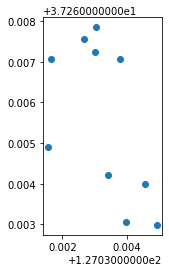

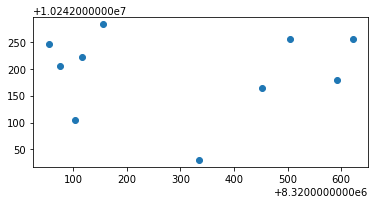

In [8]:
points = get_inside(d_list, fire_center, 300)
print(points.crs)
print(points)
points.plot()

proj_points = points.to_crs('+proj=aea +lat_1=29.5 +lat_2=42.5')
print(proj_points.crs)
print(proj_points)
proj_points.plot()

C:\Users\Jaeeun Kim\anaconda3\envs\concave\lib\site-packages\shapely\ops.py:42: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  source = iter(source)


                                            geometry
0  POLYGON ((8320621.905 10242256.426, 8320591.50...
                                            geometry
0  POLYGON ((127.03492 37.26298, 127.03397 37.263...
<class 'geopandas.geoseries.GeoSeries'>


C:\Users\Jaeeun Kim\anaconda3\envs\concave\lib\site-packages\alphashape\optimizealpha.py:41: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return all([polygon.intersects(point) for point in points])


<AxesSubplot:>

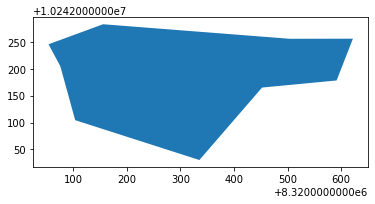

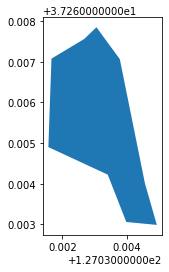

In [9]:
hull = alphashape.alphashape(proj_points)
hull.plot()
print(hull)

hull = hull.to_crs('epsg:4326')
print(hull)
print(type(hull['geometry']))
hull.plot()

In [10]:
a = hull.iat[0,0].exterior.coords

hull_points = pd.DataFrame(a, columns=['longitude', 'latitude'])
hull_points = hull_points[['latitude', 'longitude']].values.tolist()

folium.Polygon(hull_points, tooltip="hull", fill_color='blue').add_to(fmap)
fmap

In [11]:
def nearest_point(d_list, point_id, center):
	center_dist = haversine_distance(d_list[point_id], center)
	# print(center_dist)
	# for i in range(0, len(d_list) - 1):
	# 	dist = haversine_distance()

	dist_value = [(haversine_distance(d_list[point_id], d_list[i]), i)
					for i in range(0, len(d_list) - 1)
					if haversine_distance(d_list[i], center) > center_dist]
	# print(dist_value)
	print(min(dist_value))

	# for i in range(0, len(d_list) - 1):
	# 	print(haversine_distance(d_list[point_id], d_list[i]))

In [12]:
def get_geom_point(geom):
	return (geom.y, geom.x)

In [13]:
def get_next_position(d_list, center, points):
	# next_points = gpd.GeoDataFrame()
	for j in range(0, len(points)):
		center_dist = haversine_distance(get_geom_point(points.at[j, 'geometry']), center)
		dist_value = [(haversine_distance(get_geom_point(points.at[j, 'geometry']), d_list[i]), i)
						for i in range(0, len(d_list) - 1)
						if haversine_distance(d_list[i], center) > center_dist]
		# print(min(dist_value))
		# if pd.concat([points['id'], pd.Series([min(dist_value)[1]])]).is_unique:

		points.at[j, 'id'] = min(dist_value)[1]
		points.at[j, 'geometry'] = Point(d_list[min(dist_value)[1]][1], d_list[min(dist_value)[1]][0])

   id                    geometry
0  17  POINT (127.03166 37.26708)
1  29  POINT (127.03267 37.26756)
2  34  POINT (127.03299 37.26725)
3  36  POINT (127.03397 37.26306)
4  44  POINT (127.03492 37.26298)
5  45  POINT (127.03377 37.26707)
6  53  POINT (127.03156 37.26490)
7  62  POINT (127.03340 37.26422)
8  69  POINT (127.03305 37.26785)
9  85  POINT (127.03455 37.26400)
   id                    geometry
0  49  POINT (127.03075 37.26732)
1  69  POINT (127.03305 37.26785)
2  29  POINT (127.03267 37.26756)
3  64  POINT (127.03463 37.26256)
4  64  POINT (127.03463 37.26256)
5  34  POINT (127.03299 37.26725)
6  17  POINT (127.03166 37.26708)
7  85  POINT (127.03455 37.26400)
8  98  POINT (127.03221 37.26830)
9  36  POINT (127.03397 37.26306)


<AxesSubplot:>

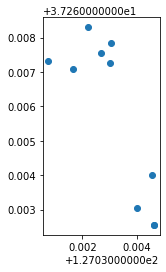

In [14]:
print(points)
get_next_position(d_list, fire_center, points)
print(points)
# print(points['id'].concat(pd.Series([17])))
# print(pd.concat([points['id'], pd.Series([17])]).is_unique)
# print(points)
points.plot()

C:\Users\Jaeeun Kim\anaconda3\envs\concave\lib\site-packages\shapely\ops.py:42: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  source = iter(source)


                                            geometry
0  POLYGON ((8320117.186 10242222.951, 8320503.63...
                                            geometry
0  POLYGON ((127.03299 37.26725, 127.03455 37.264...
<class 'geopandas.geoseries.GeoSeries'>


C:\Users\Jaeeun Kim\anaconda3\envs\concave\lib\site-packages\alphashape\optimizealpha.py:41: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return all([polygon.intersects(point) for point in points])


<AxesSubplot:>

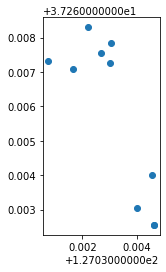

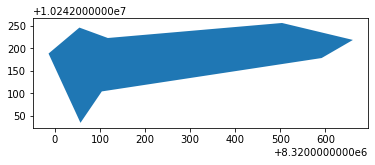

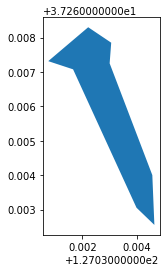

In [15]:
points.plot()
proj_points = points.to_crs('+proj=aea +lat_1=29.5 +lat_2=42.5')

hull = alphashape.alphashape(proj_points)
hull.plot()
print(hull)

hull = hull.to_crs('epsg:4326')
print(hull)
print(type(hull['geometry']))
hull.plot()


In [16]:
a = hull.iat[0,0].exterior.coords

hull_points = pd.DataFrame(a, columns=['longitude', 'latitude'])
hull_points = hull_points[['latitude', 'longitude']].values.tolist()

folium.Polygon(hull_points, tooltip="new hull", color='green' ,fill_color='green').add_to(fmap)
fmap